In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

from collections import namedtuple
from scipy.ndimage import generic_filter

import richdem as rd

import os
import elevation

In [3]:
# Stochastic CA
N = 10

layers = 5
grid = np.zeros((N,N,layers))

for i in range(N):
    for j in range(N):
        # Use small scale as tally is easier for testing
        grid[i,j,0] -= 50**2*sts.norm.pdf(i, loc = N/2, scale = N) + \
                    50**2*sts.norm.pdf(j, loc = N/2, scale = N) - 500


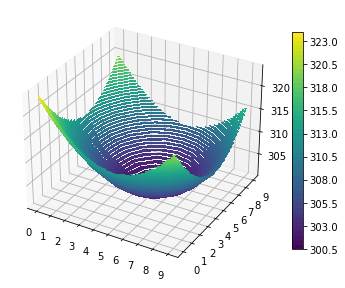

In [113]:
def view_layer(grid, layer):
    plt.imshow(grid[:,:,layer])

def view_layer(grid, layer):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1)
    lc = ax.contourf(range(N), range(N), grid[:,:,layer], 50, cmap = 'magma')
    fig.colorbar(lc, ax=ax, shrink = 0.8)

    ax.set_xticks(range(0,grid.shape[1]))
    ax.set_yticks(range(0,grid.shape[0]))
    ax.grid(alpha = 0.2)

def view_3d_layer(grid, layer):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1, projection = '3d')
    lc = ax.contourf(range(N), range(N), grid[:,:,layer], 50)
    fig.colorbar(lc, ax=ax, shrink = 0.8)

    ax.set_xticks(range(0,grid.shape[1]))
    ax.set_yticks(range(0,grid.shape[0]))
    ax.grid(alpha = 0.2)

view_3d_layer(grid, 0)

In [172]:
path = './media/beauford.npz'

with np.load(path) as data:
    dem = data['beauford']

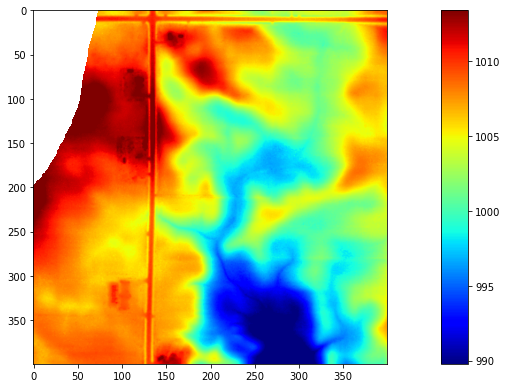

In [173]:
dem = rd.rdarray(dem[400:800,400:800], no_data=-9999)
d8_fig = rd.rdShow(dem, figsize=(8,5.5), cmap='jet')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


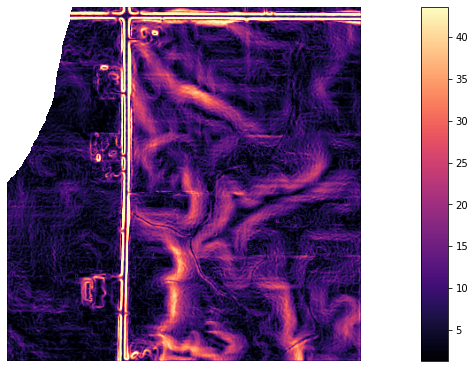

In [174]:
slope = rd.TerrainAttribute(dem, attrib='slope_degrees')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

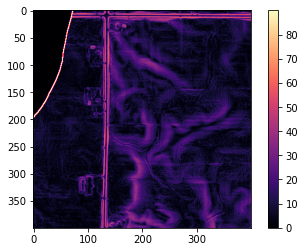

In [175]:
moore_kernel = np.ones((3,3))
moore_kernel[1,1] = 0   

slopes = generic_filter(
            dem,
            calculate_slope,
            footprint = moore_kernel,  
            mode = 'nearest',
            cval = 0)

slopes_test = slopes

plt.imshow(slopes_test, cmap = 'magma')
plt.colorbar()
plt.show()

In [179]:
slopes[200,200]

24.460587

In [14]:

def init_water(grid, fill = 1):
    # fill (m) water in cell perimenter
    water_layer = grid[...,1]

    water_layer[0,:], water_layer[-1,:] = fill, fill
    water_layer[:,0], water_layer[:, -1] = fill, fill
    return grid

def init_flood(grid):
    flood_layer  = ...
    # calc Flood flag over grid

    return grid

In [15]:
directions = {k:v for k,v in zip(range(0,8), [2**p for p in range(0,8)] )}

def find_direction(x):
    # alias: D8 in literature. Direct flow to lowest neighbor(s)
    # If multiple, split evenly
    
    # Reject is extends beyond border
    # idx is direction
    idxs = np.where(x.flatten() == x.flatten().min())
    idxs = list(*idxs)
    
    return np.sum([directions[i] for i in idxs])

def init_directions(grid):
    # idx for elevation values
    DEM = 0
    DIRECTION = 2

    moore_kernel = np.ones((3,3))
    moore_kernel[1,1] = 0   
    
    # TODO: better cval for constant mode
    # maybe repeat? 
    directions = generic_filter(
                    grid[...,DEM],
                    find_direction,
                    footprint = moore_kernel,  
                    mode = 'nearest',
                    cval = np.nan)
    
    grid[...,DIRECTION] = directions

    return 

init_directions(grid)

In [170]:
window = np.arange(0,8)

window[[1,1,1]]

array([1, 1, 1])

In [171]:
def calculate_slope(window, d = 1):

    df_dx = (np.sum(window[[2, 4, 4, 7]])  - np.sum(window[[0, 3, 3, 5]]))/8*d
    df_dy = (np.sum(window[[5, 6, 6, 7]])  - np.sum(window[[0, 1, 1, 2]]))/8*d

    rise_run = np.sqrt(df_dx**2 + df_dy**2)

    # Degree with rise/run
    degree_slope = np.arctan(rise_run) * 57.29578

    return degree_slope

def init_slope(grid):
    # idx for elevation values
    DEM = 0
    SLOPE = 3

    
    moore_kernel = np.ones((3,3))
    moore_kernel[1,1] = 0   
    
    slopes = generic_filter(
                grid[...,DEM],
                calculate_slope,
                footprint = moore_kernel,  
                mode = 'nearest',
                cval = 0)
    
    grid[...,SLOPE] = slopes

    return 
    
init_slope(grid)

In [165]:
# liquid loss = inflitration
depth = np.linspace(0,5,100)
s = np.linspace(0,90,100)
n = 0.2

w = 10

def fluid_velocity(cell, n = 0.2):
    """Params
        depth[m]   (int): depth of water column at cell
        s[deg]   (float): slope of cell
        n        (float): Manning roughness coefficient."""

    depth = cell[0]
    s     = cell[2]

    return np.cbrt(depth**2)*np.sqrt(s)/n

def time_through_cell(width = 10, cell):
    """Params
        v    (float): calculated fluid_velocity through cell
        width  (int): width of cell/raster resolution"""

    v = fluid_velocity(cell)

    return width/v

def volume_entering(depth, width, v, t = 1):
    return depth * width * v * t

# Meet flooding conditions
def is_flooded(cell, t = 1):
    """check if cell is flooded
    Params
    Returns
        flooded? (bool)"""
    return time_through_cell(cell) > t


def infiltration_velocity(Ks = 2, Hf = 1, F = 2, Md = 3):
    """
    Params
        Ks(mmh^-1) : hydraulic conductivity
        Hf(mm)     : suction list
        Md(mm)     : soil moisture deficit
        F          : total depth of infiltration
    """
    # WTF is F???
    return Ks*(1 + Hf*Md/F)

    

SyntaxError: non-default argument follows default argument (<ipython-input-165-2f6d5c9e619c>, line 19)

In [ ]:
def compute_flow(x):
    # Reject is extends beyond border :: water flowing outside exits 
    if not np.isnan(x).any():
        pass

    return 0

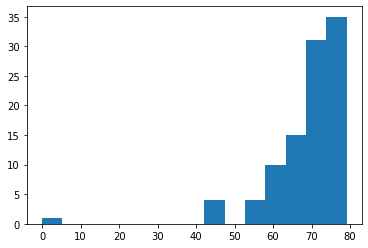

In [184]:
# Distribution of angles? :: should be normalish
def hist_angles(grid):
    plt.hist(grid[...,3].flatten(), bins = 15)
    plt.show()

hist_angles(grid)

pre-processing input data; 

height of water column vs DEM height>
direction vs slope?
"detects water" 



4 grids
    0. water level
        **height of water column (float m)** in cell
            init: >0 if water else 0
    
    1. flooded cell grid
        FLOODED? **bool** flag on flooding conditions
            if flooded, can transfer water to neighboring cells
            flooding conditions:

    2. **direction** grid
        each cell [1,255]
            
        ![](./media/directions.jpg)
        preffered cell direction of water flow is one of 6 vals,
                NW, N, NE, W, E, SW, S, SE = 1,2,4,8,16,32,64,128
                *or everything lower?*
            determined by considering **height** in 8 neighbors
                lowest height = direction
                    for ex N = -10, [...EWS] = 0, N is preffered
                    N = 2 (while E = 4, W = 8 etc)
                if >1 cell have the same lowest height, 
                    use sum of directions
                    therefore, each cell [1,255] (255 if every cell has same elevation)
                
    3. slope grid
        generated from DEM, calculates **slope across neighborhood** for each cell

        tg(slope) = root(change_x^2 + change_y^2)
            df/dx = (h1,3 + h2,3 + h3,3 - h1,1 - h2,1 - h3,1) / 6
            df/dy = (h3,1 + h3,2 + h3,3 - h1,1 - h1,2 - h1,3) / 6
            h is contents of DEM in each cell (height)
                result: value of slope in degrees

for iter in iterations:
    temp_drain = np.zeros((N,N))
    temp_water = np.zeros((N,N))
    for i in N:
        for j in N:

            cell = grid[i,j]

            is cell[water] > 0:
                if water in cell.neighborhood:
                    check directions of flow in neighbors
                        if direction towards cell 
                            if cell is activated:
                                water_spread = calc_water_spread()
                                temp_water[i,j] = sw
                            if water in cell:
                                if cell with water == activated:
                                    water_drain = calc_water_drain()
                                    temp_drain[i,j] = water_drain

    water_grid += temp_water - temp_drain



DEM = Digital elevation model or DMT (Digital Model of Terrain)
    used to init model and params:
        grid init:
            1500m * 1500m 
            DEM for each thing, with raster 10m
                raster  = increments of 10
                width = resolution
                each cell = elevation info
        param init:
            Land Cover
                surface roughness, inflitration ~> rate of spread
                    rep: separate layers, or constant Manning coefficient for whole sim
                        0.011 for rocky (fast flow), **0.2** for vegetation (slow flow)           

In [196]:
# Erosion
# props[0] = 0: produces flow, -1: no flow, -2:NoData

# Rho : weight probability by slope
methods = ['D8','D4','Rho8', 'Rho4', 'Quinn', 'Freeman', 'Dinf']

flow = rd.FlowProportions(dem, method = 'D8')

flow[200:205,200:205]

# Short time scale

#Different Flow Methods
# D8
# Quinn: to all cells, but as a function of slope to neighbor

"""
234
105
876
"""

# get water to move down a slope on the grid

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


'\n234\n105\n876\n'

# DEM -> CA -> Run -> Raster DEM Projection

## Working with Rasters
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/reproject-raster/
+ [] Copy paste example!

https://rasterio.readthedocs.io/en/latest/topics/reproject.html

## Raster DEM Projection
+ A raster dataset is projected into a new spatial reference using a bilinear interpolation approximation method that projects pixels on a coarse mesh grid and uses bilinear interpolation between the pixels

### Flow Methods
Different ways of flow
https://richdem.readthedocs.io/en/latest/flow_metrics.html

# Plot of Flow Lines


# Localized Rain
Or flow generation could be concentrated to an area, as if there were a localized rain event:

#Make a circular region of flow generation

#Create coordinate grids
yy, xx = np.mgrid[:dem.shape[0], :dem.shape[1]]
#Find squared distance from center of grid
circle = (xx - dem.shape[1]/2) ** 2 + (yy - dem.shape[0]/2) ** 2
#Take only those cells within a radius
circle = (circle < 200**2).astype('float64')

#Don't modify the original accumulation data. Return a new matrix with flow
#accumulation values.
accum  = rd.FlowAccumulation(dem, method='D8', weights=circle, in_place=False)

d8_fig = rd.rdShow(accum, ignore_colours=[0], figsize=(8,5.5), axes=False, cmap='jet')

https://richdem.readthedocs.io/en/latest/flow_accumulation.html#from-flow-proportions

How does water circulate the system? 
    Runoff
    Hydrologic Production

This does not consider rainfall. How should it be added? 

+ https://www.goldensoftware.com/blog/creating-terrain-slope-maps-from-a-digital-elevation-models-in-surfer
+   D8 : least transverse deciation
    + intersect contout lines at 90 degrees
+ https://geol260.academic.wlu.edu/course-notes/digital-terrain-analyses/digital-terrain-analysis-3/

+ https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/what-is-raster-data.htm
+ Data stored in a raster format represents real-world phenomena:

Thematic data (also known as discrete) represents features such as land-use or soils data.
Continuous data represents phenomena such as temperature, elevation, or spectral data such as satellite images and aerial photographs.
Rasters as thematic maps
Rasters representing thematic data can be derived from analyzing other data. A common analysis application is classifying a satellite image by land-cover categories


 This 1-arc second global digital elevation model has a spatial resolution of about 30 meters. Also, it covers most of the world with an absolute vertical height accuracy of less than 16m.

 ### Slope Calculation Formula
 https://geol260.academic.wlu.edu/course-notes/digital-terrain-analyses/digital-terrain-analysis-3/

 Barnes, Richard. 2016. RichDEM: Terrain Analysis Software. http://github.com/r-barnes/richdem
+ has a blazing fast implementation of slope stuff


file:///Users/andrevacha/Downloads/download.pdf
    Horn paper is where you get the slope thing from 
